In [2]:
ls

2Autoencoder.ipynb        lens_1000_no_sc.h5        LSST_EUCLID.ipynb
Dark_satelite2.ipynb      lens_10k_no_sc.h5         LSST_generator.py
Dark_satelite.ipynb       lens_2000_no_sc.h5        VAE.ipynb
generator_LSST.ipynb      lens_dataset_2000.h5      VAE_LSST.ipynb
generator_notebook.ipynb  lens_dataset.h5
generator.py              lens_dataset_lsst_rgb.h5


In [3]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.utils.data import TensorDataset
from tqdm import trange

import torch.nn.functional as F

Available datasets: ['delta_psi_maps', 'images_clean', 'images_rgb', 'subhalo_mass', 'subhalo_x', 'subhalo_y']
images_rgb shape: (5, 40, 40, 3)
images_clean shape: (5, 40, 40, 3)
delta_psi_maps shape: (5, 40, 40)
subhalo_mass shape: (5,)
subhalo_x shape: (5,)
subhalo_y shape: (5,)
Plotting samples: [3 0 1]


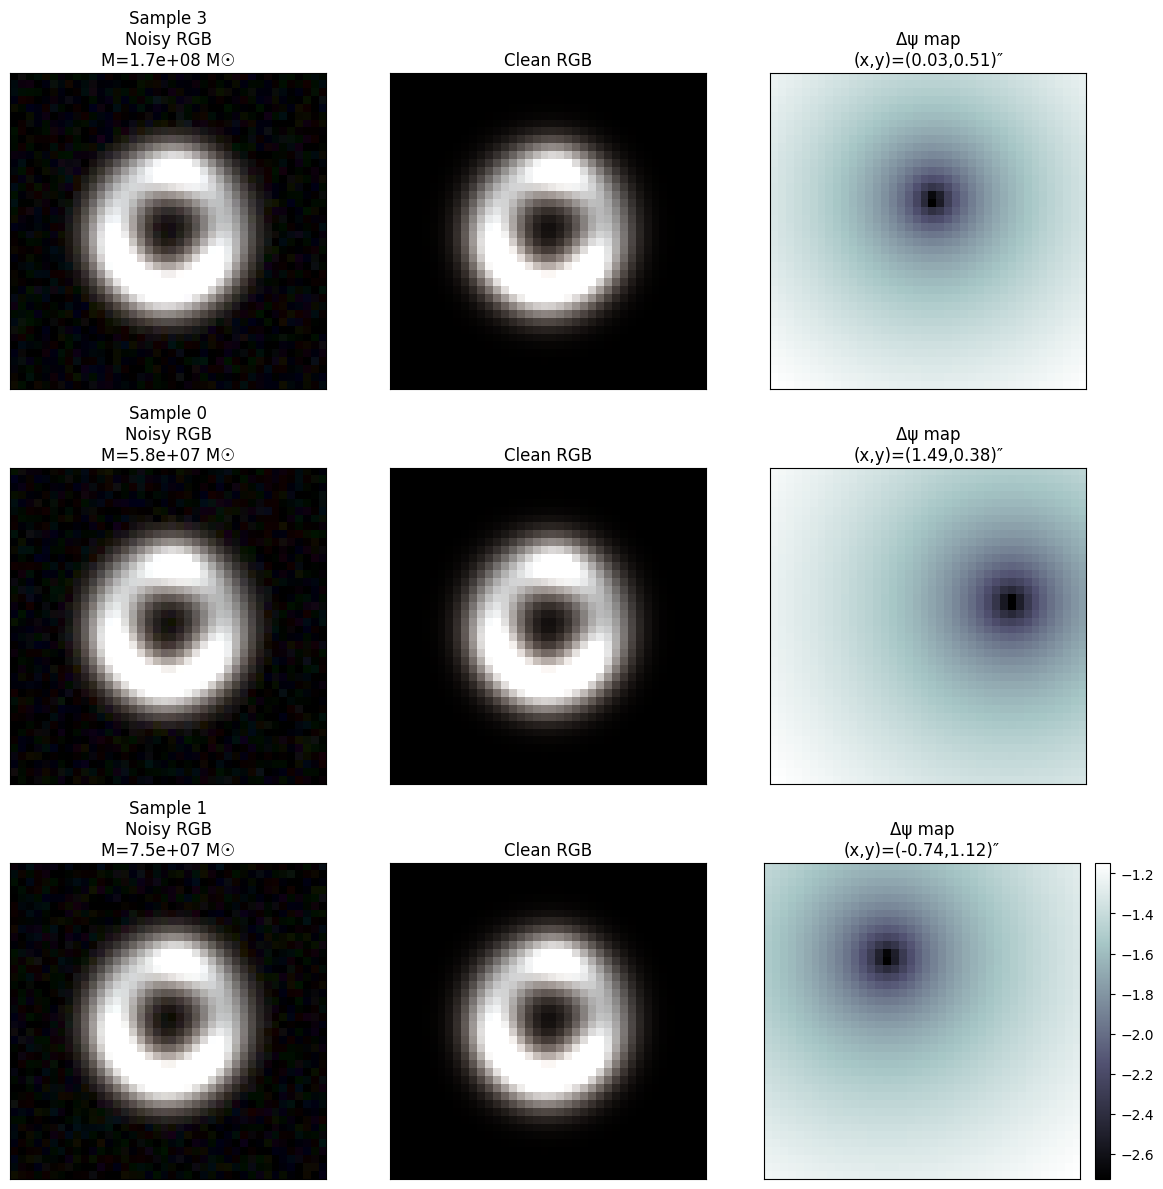

In [4]:
# Path to the new RGB HDF5 dataset
h5_path = 'lens_dataset_lsst_rgb.h5'

with h5py.File(h5_path, 'r') as f:
    print("Available datasets:", list(f.keys()))
    print("images_rgb shape:", f['images_rgb'].shape)
    print("images_clean shape:", f['images_clean'].shape)
    print("delta_psi_maps shape:", f['delta_psi_maps'].shape)
    print("subhalo_mass shape:", f['subhalo_mass'].shape)
    print("subhalo_x shape:", f['subhalo_x'].shape)
    print("subhalo_y shape:", f['subhalo_y'].shape)

    # Choose three random sample indices
    N = f['images_rgb'].shape[0]
    sample_indices = np.random.choice(N, size=3, replace=False)
    print("Plotting samples:", sample_indices)

    # Create figure with 3 rows and 3 columns
    fig, axes = plt.subplots(3, 3, figsize=(12, 12), sharex=True, sharey=True)

    for row, idx in enumerate(sample_indices):
        img_rgb     = f['images_rgb'][idx]    # shape (ny, nx, 3)
        img_clean   = f['images_clean'][idx]  # shape (ny, nx, 3)
        delta_psi   = f['delta_psi_maps'][idx]
        mass        = f['subhalo_mass'][idx]
        x_sub, y_sub = f['subhalo_x'][idx], f['subhalo_y'][idx]

        # Panel 1: RGB image with noise
        axes[row, 0].imshow(img_rgb, origin='lower')
        axes[row, 0].set_title(f"Sample {idx}\nNoisy RGB\nM={mass:.1e} M☉")

        # Panel 2: RGB image clean (no subhalo, no noise)
        axes[row, 1].imshow(img_clean, origin='lower')
        axes[row, 1].set_title("Clean RGB")

        # Panel 3: Δψ map
        im2 = axes[row, 2].imshow(delta_psi, origin='lower', cmap='bone')
        axes[row, 2].set_title(f"Δψ map\n(x,y)=({x_sub:.2f},{y_sub:.2f})″")

        # Colorbar only for Δψ on the last row
        if row == 2:
            fig.colorbar(im2, ax=axes[row, 2], fraction=0.046, pad=0.04)

    for ax in axes.flatten():
        ax.set_xticks([])
        ax.set_yticks([])

    plt.tight_layout()
    plt.show()


In [5]:
# 1) Load the data from the HDF5 file
with h5py.File(h5_path, 'r') as f:
    X_noisy  = f['images_rgb'][:]    # (N, H, W, 3)
    Y_smooth = f['images_clean'][:]   # (N, H, W, 3)
    Y_delta  = f['delta_psi_maps'][:]  # (N, H, W, 3)
    sub_mass = f['subhalo_mass'][:]  # (N,)
    sub_x    = f['subhalo_x'][:]     # (N,)
    sub_y    = f['subhalo_y'][:]     # (N,)

In [6]:
X_noisy.shape

(5, 40, 40, 3)

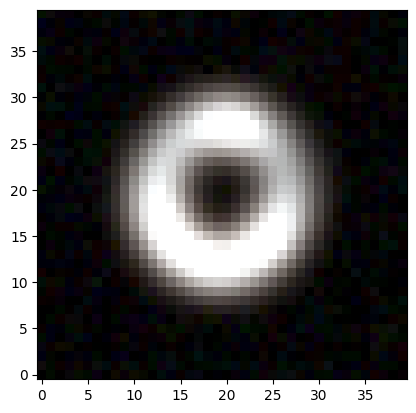

In [7]:
plt.imshow(X_noisy[0], origin='lower')

### Step 2: Pre-processing

We first remove any invalid entries (NaN or ±Inf), then wrap the arrays into PyTorch tensors and add the channel dimension.




In [8]:
# 2) Clean the data (mismo que antes)
X_noisy = np.nan_to_num(X_noisy, nan=0.0, posinf=None, neginf=None)
Y_smooth = np.nan_to_num(Y_smooth, nan=0.0, posinf=None, neginf=None)
Y_delta  = np.nan_to_num(Y_delta,  nan=0.0, posinf=None, neginf=None)
sub_mass = np.nan_to_num(sub_mass, nan=0.0, posinf=None, neginf=None)
sub_x    = np.nan_to_num(sub_x,    nan=0.0, posinf=None, neginf=None)
sub_y    = np.nan_to_num(sub_y,    nan=0.0, posinf=None, neginf=None)

# 3) Convertir a tensores en formato channel-first
# X_noisy: (N, H, W, 3) -> (N, 3, H, W)
X  = torch.from_numpy(X_noisy).permute(0, 3, 1, 2).float()

# Y_smooth: si también es RGB (N, H, W, 3) -> (N, 3, H, W)
Y1 = torch.from_numpy(Y_smooth).permute(0, 3, 1, 2).float()

# Y_delta: 1 canal (N, H, W) -> (N, 1, H, W)
Y2 = torch.from_numpy(Y_delta).float().unsqueeze(1)


In [9]:
#Split the data into training, validation, and test sets
# 1) Índices para cada subconjunto
idx = np.arange(X.shape[0])

# 10% para test
idx_rest, idx_test = train_test_split(idx, test_size=0.10, random_state=42)

# De lo que queda (90%), separar 20% para validación → equivale a 2/9 ≈ 22.22%
idx_train, idx_val = train_test_split(idx_rest, test_size=2/9, random_state=42)

# 2) Split de imágenes
X_train, X_val, X_test   = X[idx_train],  X[idx_val],  X[idx_test]
Y1_train, Y1_val, Y1_test = Y1[idx_train], Y1[idx_val], Y1[idx_test]
Y2_train, Y2_val, Y2_test = Y2[idx_train], Y2[idx_val], Y2[idx_test]

# 3) Split de masa y coordenadas
sub_mass_train, sub_mass_val, sub_mass_test = sub_mass[idx_train], sub_mass[idx_val], sub_mass[idx_test]
sub_x_train, sub_x_val, sub_x_test = sub_x[idx_train], sub_x[idx_val], sub_x[idx_test]
sub_y_train, sub_y_val, sub_y_test = sub_y[idx_train], sub_y[idx_val], sub_y[idx_test]

### Normalization

In [10]:
Y_delta.shape# 6) Normalize the data.
# For RGB images: mean and std per channel
mean_X  = X_train.mean(dim=(0, 2, 3), keepdim=True)  # shape (1, 3, 1, 1)
std_X   = X_train.std(dim=(0, 2, 3), keepdim=True)

mean_Y1 = Y1_train.mean()
std_Y1  = Y1_train.std()
mean_Y2 = Y2_train.mean()
std_Y2  = Y2_train.std()

mean_mass, std_mass = sub_mass_train.mean(), sub_mass_train.std()
mean_x, std_x       = sub_x_train.mean(), sub_x_train.std()
mean_y, std_y       = sub_y_train.mean(), sub_y_train.std()

def normalize(t, m, s):
    return (t - m) / s

# Apply normalization
X_train = normalize(X_train, mean_X, std_X)
X_val   = normalize(X_val,   mean_X, std_X)
X_test  = normalize(X_test,  mean_X, std_X)

Y1_train = normalize(Y1_train, mean_Y1, std_Y1)
Y1_val   = normalize(Y1_val,   mean_Y1, std_Y1)
Y1_test  = normalize(Y1_test,  mean_Y1, std_Y1)

Y2_train = normalize(Y2_train, mean_Y2, std_Y2)
Y2_val   = normalize(Y2_val,   mean_Y2, std_Y2)
Y2_test  = normalize(Y2_test,  mean_Y2, std_Y2)

sub_mass_train = normalize(sub_mass_train, mean_mass, std_mass)
sub_mass_val   = normalize(sub_mass_val,   mean_mass, std_mass)
sub_mass_test  = normalize(sub_mass_test,  mean_mass, std_mass)

sub_x_train = normalize(sub_x_train, mean_x, std_x)
sub_x_val   = normalize(sub_x_val,   mean_x, std_x)
sub_x_test  = normalize(sub_x_test,  mean_x, std_x)

sub_y_train = normalize(sub_y_train, mean_y, std_y)
sub_y_val   = normalize(sub_y_val,   mean_y, std_y)
sub_y_test  = normalize(sub_y_test,  mean_y, std_y)


In [11]:
#Datasats for training, witg shape (N, 3)
mxy_train = torch.tensor(np.array([sub_mass_train, sub_x_train, sub_y_train])).float().T  # (N, 3)
mxy_val   = torch.tensor(np.array([sub_mass_val, sub_x_val, sub_y_val])).float().T
mxy_test  = torch.tensor(np.array([sub_mass_test, sub_x_test, sub_y_test])).float().T   

### 📦 7) Dataset and DataLoader

This section prepares the datasets and data loaders used during training, validation, and testing.

---

#### 🔹 1) Create TensorDatasets

We package the input and target tensors into `TensorDataset` objects. This allows us to efficiently iterate through the data during training and evaluation.

```python
train_ds = TensorDataset(X_train, Y1_train, Y2_train, mxy_train)
val_ds   = TensorDataset(X_val,   Y1_val,   Y2_val, mxy_val)


In [12]:
from torch.utils.data import TensorDataset, DataLoader
import torch

batch = 32
on_cuda = torch.cuda.is_available()

# 1) Datasets
train_ds = TensorDataset(X_train, Y1_train, Y2_train, mxy_train)
val_ds   = TensorDataset(X_val,   Y1_val,   Y2_val,   mxy_val)
test_ds  = TensorDataset(X_test,  Y1_test,  Y2_test,  mxy_test)

# 2) DataLoaders
common_kwargs = dict(
    batch_size=batch,
    num_workers=4,
    pin_memory=on_cuda,
    persistent_workers=True
)

train_loader = DataLoader(
    train_ds,
    shuffle=True,
    drop_last=True,
    **common_kwargs
)

val_loader = DataLoader(
    val_ds,
    shuffle=False,
    drop_last=False,
    **common_kwargs
)

test_loader = DataLoader(
    test_ds,
    shuffle=False,
    drop_last=False,
    **common_kwargs
)


In [13]:
g = torch.Generator()
g.manual_seed(42)
train_loader = DataLoader(train_ds, shuffle=True, generator=g, drop_last=True, **common_kwargs)

In [14]:
# Device
# 1) Detectar device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


🧠 DualVAE: Variational Autoencoder with Physical Regression

This model is a **Variational Autoencoder (VAE)** designed to process gravitational lensing data. It performs:

- **Dual reconstruction**:
  - A smooth background light source.
  - A lensing potential perturbation map (ΔΨ).
- **Regression of physical parameters**:
  - Subhalo **mass**, **x-position**, and **y-position**.

---

#### 🔹 Encoder

The encoder consists of **3 convolutional layers** with:
- 3×3 kernel, stride 2, padding 1 (downsampling by 8× total),
- ReLU activations,
- Dropout for regularization (`p=0.3`).

These layers transform the input image into a feature map, which is then flattened and projected into the latent space using two linear layers:
- `fc_mu` → mean vector `μ` (for latent variable)
- `fc_logvar` → log variance `logσ²`

---

#### 🔹 Latent Space & Sampling

To enable backpropagation through stochastic sampling, the model uses the **reparameterization trick**:

```python
z = mu + eps * std

self.fc_regs = nn.Sequential(
    nn.Linear(z_dim, z_dim // 2),
    nn.Tanh(),
    nn.Dropout(0.1),
    nn.Linear(z_dim // 2, 3)
)


In [39]:
# VAE Model (RGB smooth + 1ch delta) para H=W=40
class DualVAE(nn.Module):
    def __init__(self, in_ch=3, base_ch=16, z_dim=128, H=40, W=40):
        super().__init__()
        # ——— Encoder (3 convs stride=2) → (H/8, W/8) = (5,5) si H=W=40
        self.enc = nn.Sequential(
            nn.Conv2d(in_ch,     base_ch,   3, 2, 1), nn.ReLU(), nn.Dropout(0.3),
            nn.Conv2d(base_ch,   base_ch*2, 3, 2, 1), nn.ReLU(), nn.Dropout(0.3),
            nn.Conv2d(base_ch*2, base_ch*4, 3, 2, 1), nn.ReLU(), nn.Dropout(0.3),
        )

        # Tamaños tras las 3 convs (para 40→20→10→5)
        def conv_out(sz): return (sz + 2*1 - 3)//2 + 1
        H1, W1 = conv_out(H),    conv_out(W)   # 20
        H2, W2 = conv_out(H1),   conv_out(W1)  # 10
        H3, W3 = conv_out(H2),   conv_out(W2)  # 5

        self._C3 = 4 * base_ch
        self._H3 = H3
        self._W3 = W3
        feat_dim = self._C3 * H3 * W3

        # ——— VAE stats
        self.fc_mu     = nn.Linear(feat_dim, z_dim)
        self.fc_logvar = nn.Linear(feat_dim, z_dim)

        # ——— z → feature map
        self.fc_dec = nn.Linear(z_dim, feat_dim)

        # ——— Decoders: usa opad=1 en TODAS las deconvs (5→10→20→40)
        # Smooth (3 canales)
        self.decoder_s = nn.Sequential(
            nn.ReLU(),
            nn.Unflatten(1, (self._C3, self._H3, self._W3)),                       # (N, 4C, 5, 5)
            nn.ConvTranspose2d(self._C3,   self._C3//2, 3, 2, 1, output_padding=1),# 5→10
            nn.ReLU(), nn.Dropout(0.3),
            nn.ConvTranspose2d(self._C3//2, base_ch,      3, 2, 1, output_padding=1),# 10→20
            nn.ReLU(), nn.Dropout(0.3),
            nn.ConvTranspose2d(base_ch,     3,            3, 2, 1, output_padding=1) # 20→40
        )
        # Δψ (1 canal)
        self.decoder_d = nn.Sequential(
            nn.ReLU(),
            nn.Unflatten(1, (self._C3, self._H3, self._W3)),
            nn.ConvTranspose2d(self._C3,   self._C3//2, 3, 2, 1, output_padding=1), # 5→10
            nn.ReLU(), nn.Dropout(0.3),
            nn.ConvTranspose2d(self._C3//2, base_ch,      3, 2, 1, output_padding=1),# 10→20
            nn.ReLU(), nn.Dropout(0.3),
            nn.ConvTranspose2d(base_ch,     1,            3, 2, 1, output_padding=1) # 20→40
        )

        # ——— Cabezal de regresión (m, x, y) desde μ
        self.fc_regs = nn.Sequential(
            nn.Linear(z_dim, z_dim//2),
            nn.Tanh(), nn.Dropout(0.1),
            nn.Linear(z_dim//2, 3)
        )

    def encode(self, x):
        h = self.enc(x)
        h = h.view(h.size(0), -1)
        mu, logvar = self.fc_mu(h), self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = (0.5 * logvar).exp()
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.fc_dec(z)
        s = self.decoder_s(h)  # (N, 3, 40, 40)
        d = self.decoder_d(h)  # (N, 1, 40, 40)
        return s, d

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        s, d = self.decode(z)
        mxy_pred = self.fc_regs(mu)  # (N, 3)
        return s, d, mu, logvar, mxy_pred


In [40]:
model = DualVAE(in_ch=3, base_ch=20, z_dim=128, H=40, W=40).to(device)


In [41]:
# 3.3) Optimizer (puede quedarse igual)
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=0.001,  # learning rate
    weight_decay=1e-4
)

In [42]:
# Loss function for the VAE and regression (adapted for RGB input)
def combined_loss(s_pred, s_true,
                  d_pred, d_true,
                  mu, logvar,
                  mxy_pred, mxy_true,
                  alpha=1.0, beta=1e-3, gamma=1.0):
    """
    Combined loss for multitask VAE:
    - Reconstruction loss for smooth image and Δψ map
    - KL divergence for latent space regularization
    - Regression loss for mass and position (m, x, y)

    Args:
        s_pred, s_true: Predicted and ground truth smooth images  (B, C, H, W)
        d_pred, d_true: Predicted and ground truth Δψ images      (B, 1, H, W)
        mu, logvar: Mean and log-variance from encoder
        mxy_pred, mxy_true: Predicted and ground truth (m, x, y)  (B, 3)
        alpha: weight for Δψ reconstruction loss
        beta:  weight for KL divergence
        gamma: weight for regression loss
    """
    # Reconstruction loss (smooth + alpha*Δψ)
    recon = F.mse_loss(s_pred, s_true) + alpha * F.mse_loss(d_pred, d_true)

    # KL divergence
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    kl /= s_pred.size(0)

    vae_l = recon + beta * kl

    # Regression loss for (m, x, y)
    reg_l = F.mse_loss(mxy_pred, mxy_true)

    return vae_l + gamma * reg_l


In [43]:
from torch.cuda.amp import autocast, GradScaler

scaler = GradScaler(enabled=torch.cuda.is_available())

def train_epoch(loader, optimizer, alpha=1.0, beta=1e-3, gamma=1.0):
    model.train()
    running_loss = 0.0
    for x, y_s, y_d, mxy in loader:
        # non_blocking aprovecha pin_memory=True
        x   = x.to(device, non_blocking=True)
        y_s = y_s.to(device, non_blocking=True)
        y_d = y_d.to(device, non_blocking=True)
        mxy = mxy.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        # AMP opcional (acelera en GPU, iguala en CPU)
        with autocast(enabled=torch.cuda.is_available()):
            p_s, p_d, mu, logvar, mxy_pred = model(x)
            loss = combined_loss(p_s, y_s, p_d, y_d, mu, logvar, mxy_pred, mxy,
                                 alpha, beta, gamma)

        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * x.size(0)

    return running_loss / len(loader.dataset)

def eval_epoch(loader, alpha=1.0, beta=1e-3, gamma=1.0):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for x, y_s, y_d, mxy in loader:
            x   = x.to(device, non_blocking=True)
            y_s = y_s.to(device, non_blocking=True)
            y_d = y_d.to(device, non_blocking=True)
            mxy = mxy.to(device, non_blocking=True)

            with autocast(enabled=torch.cuda.is_available()):
                p_s, p_d, mu, logvar, mxy_pred = model(x)
                loss = combined_loss(p_s, y_s, p_d, y_d, mu, logvar, mxy_pred, mxy,
                                     alpha, beta, gamma)

            running_loss += loss.item() * x.size(0)

    return running_loss / len(loader.dataset)


In [44]:
from tqdm import trange

# Training loop
num_epochs = 30
alpha = 1.0
beta  = 1e-3
gamma = 1.0

train_losses = []
val_losses   = []

# barra externa por época
outer_bar = trange(1, num_epochs+1, desc="Epoch", ncols=100, colour="#47def8")

for epoch in outer_bar:
    train_loss = train_epoch(train_loader, optimizer, alpha, beta, gamma)
    val_loss   = eval_epoch(val_loader, alpha, beta, gamma)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    outer_bar.set_postfix(train=f"{train_loss:.4f}", val=f"{val_loss:.4f}")


Epoch: 100%|██████████████████████████████| 30/30 [00:00<00:00, 58.13it/s, train=0.0000, val=6.6489]


In [45]:
x, y_s, y_d, mxy = next(iter(val_loader))
x, y_s, y_d = x.to(device), y_s.to(device), y_d.to(device)
with torch.no_grad():
    s_pred, d_pred, mu, logvar, mxy_pred = model(x)

print("X:", x.shape, "Y1:", y_s.shape, "Y2:", y_d.shape)
print("s_pred:", s_pred.shape, "d_pred:", d_pred.shape)


X: torch.Size([1, 3, 40, 40]) Y1: torch.Size([1, 3, 40, 40]) Y2: torch.Size([1, 1, 40, 40])
s_pred: torch.Size([1, 3, 40, 40]) d_pred: torch.Size([1, 1, 40, 40])


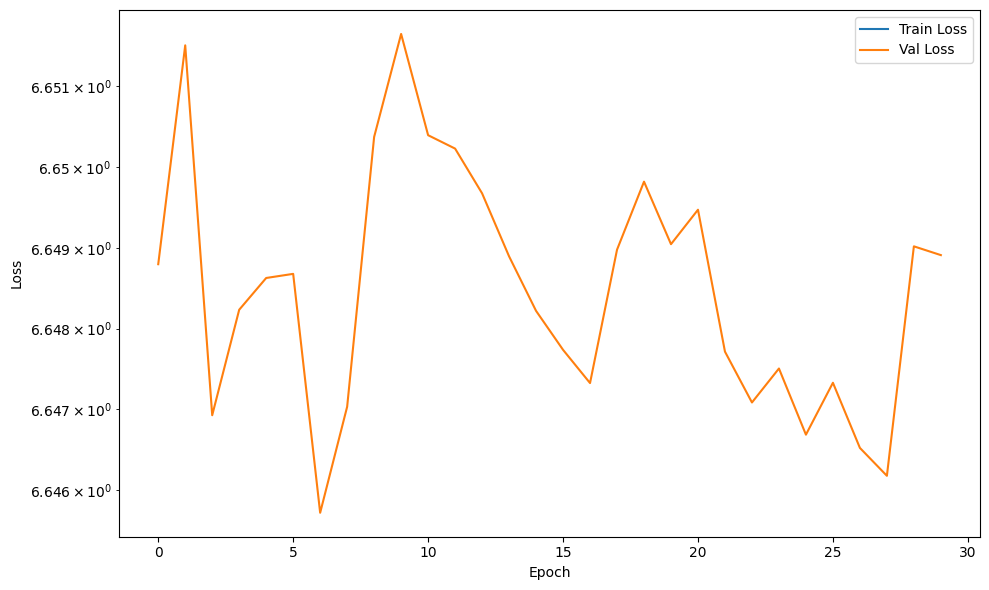

In [48]:
plt.figure(figsize=(10,6))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses,   label="Val Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.yscale('log')
plt.legend(); plt.tight_layout(); plt.show()


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

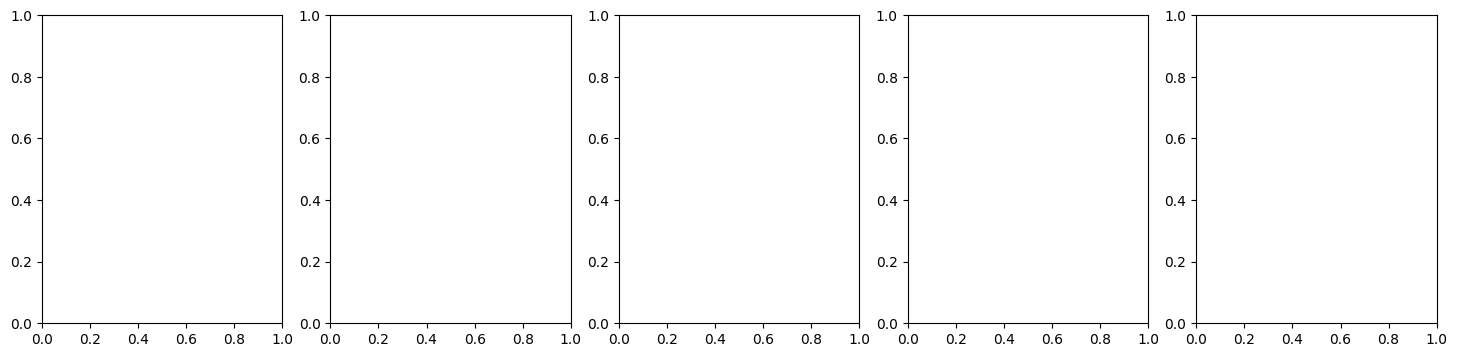

In [50]:
# === Visualización en TEST con RGB para X y Smooth ===
model.eval()
with torch.no_grad():
    x, y_true_smooth, y_true_delta, mxy_true = next(iter(test_loader))
    x, y_true_smooth, y_true_delta, mxy_true = (
        x.to(device),
        y_true_smooth.to(device),
        y_true_delta.to(device),
        mxy_true.to(device),
    )
    # forward devuelve también mxy_pred
    y_pred_smooth, y_pred_delta, mu, logvar, mxy_pred = model(x)

# 2) A CPU + NumPy
x_np         = x.detach().cpu().numpy()              # (N,3,H,W)
y_true_s_np  = y_true_smooth.detach().cpu().numpy()  # (N,3,H,W)
y_true_d_np  = y_true_delta.detach().cpu().numpy()   # (N,1,H,W)
y_pred_s_np  = y_pred_smooth.detach().cpu().numpy()  # (N,3,H,W)
y_pred_d_np  = y_pred_delta.detach().cpu().numpy()   # (N,1,H,W)
mxy_true_np  = mxy_true.detach().cpu().numpy()       # (N,3)
mxy_pred_np  = mxy_pred.detach().cpu().numpy()       # (N,3)

# 3) Plot N muestras del test set
n_samples = 1
offset    = 0  # ajusta según quieras otras muestras
N = x_np.shape[0]
assert offset + n_samples <= N, "offset+n_samples excede el tamaño del batch de test."

fig, axes = plt.subplots(n_samples, 5, figsize=(18, 4*n_samples))

for i in range(n_samples):
    idx = i + offset

    # --- valores de regresión (si están estandarizados, recuerda desnormalizar para presentar en unidades físicas) ---
    m_true, x_true, y_true = mxy_true_np[idx]
    m_pred, x_pred, y_pred = mxy_pred_np[idx]

    # --- Col 0: Entrada ruidosa (RGB) ---
    # pasa de (3,H,W) a (H,W,3)
    ax = axes[i,0]
    ax.imshow(np.clip(x_np[idx].transpose(1,2,0), 0, 1))
    ax.set_title(
        f"Noisy RGB\n"
        f"M_true={m_true:.2f}, M_pred={m_pred:.2f}\n"
        f"x_true={x_true:.2f}, x_pred={x_pred:.2f}\n"
        f"y_true={y_true:.2f}, y_pred={y_pred:.2f}"
    )
    ax.axis('off')

    # --- Col 1: Smooth real (RGB) ---
    ax = axes[i,1]
    ax.imshow(np.clip(y_true_s_np[idx].transpose(1,2,0), 0, 1))
    ax.set_title("Real smooth (RGB)")
    ax.axis('off')

    # --- Col 2: Smooth reconstruido (RGB) ---
    ax = axes[i,2]
    ax.imshow(np.clip(y_pred_s_np[idx].transpose(1,2,0), 0, 1))
    ax.set_title("Recon smooth (RGB)")
    ax.axis('off')

    # --- Col 3: Δψ real (1 canal) ---
    ax = axes[i,3]
    ax.imshow(y_true_d_np[idx,0], origin='lower', cmap='inferno')
    ax.set_title(r"Real $\Delta\Psi$")
    ax.axis('off')

    # --- Col 4: Δψ reconstruido (1 canal) ---
    ax = axes[i,4]
    ax.imshow(y_pred_d_np[idx,0], origin='lower', cmap='inferno')
    ax.set_title(r"Recon $\Delta\Psi$")
    ax.axis('off')

plt.tight_layout()
plt.show()


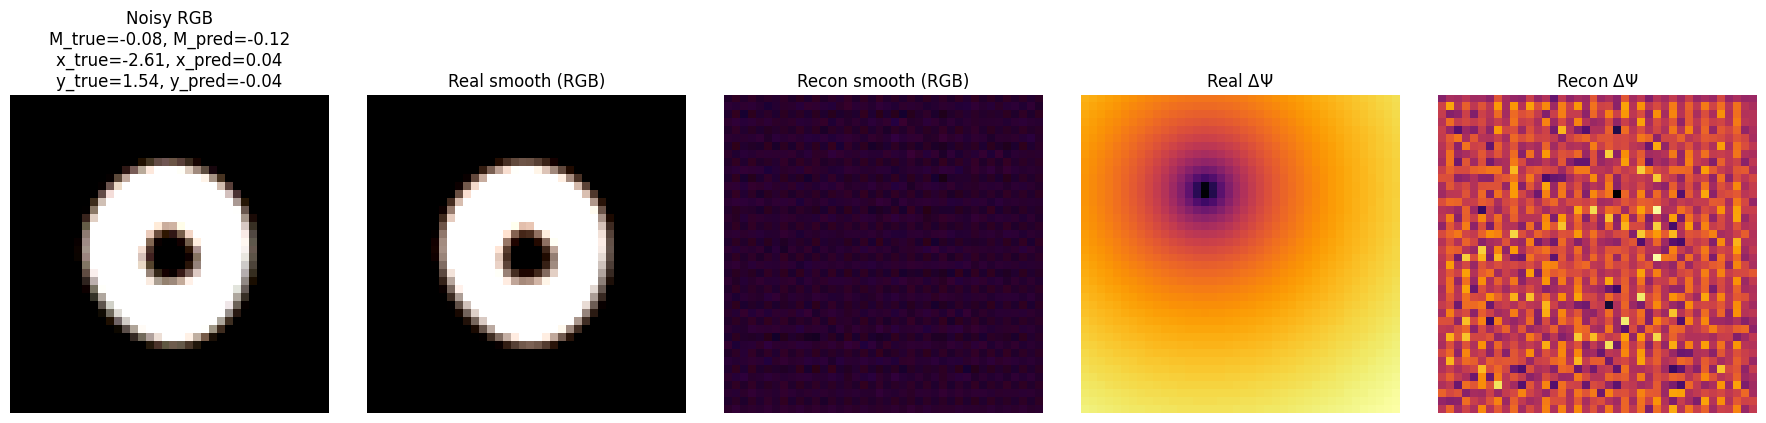

In [51]:
# === Visualización en TEST con manejo robusto de ejes y tamaños ===
model.eval()
with torch.no_grad():
    x, y_true_smooth, y_true_delta, mxy_true = next(iter(test_loader))
    x, y_true_smooth, y_true_delta, mxy_true = (
        x.to(device),
        y_true_smooth.to(device),
        y_true_delta.to(device),
        mxy_true.to(device),
    )
    y_pred_smooth, y_pred_delta, mu, logvar, mxy_pred = model(x)

# A CPU + NumPy
x_np         = x.detach().cpu().numpy()              # (N,3,H,W)
y_true_s_np  = y_true_smooth.detach().cpu().numpy()  # (N,3,H,W)
y_true_d_np  = y_true_delta.detach().cpu().numpy()   # (N,1,H,W)
y_pred_s_np  = y_pred_smooth.detach().cpu().numpy()  # (N,3,H,W)
y_pred_d_np  = y_pred_delta.detach().cpu().numpy()   # (N,1,H,W)
mxy_true_np  = mxy_true.detach().cpu().numpy()       # (N,3)
mxy_pred_np  = mxy_pred.detach().cpu().numpy()       # (N,3)

# Parámetros de muestreo
offset    = 0
max_rows  = 3
N         = x_np.shape[0]
n_samples = max(1, min(max_rows, N - offset))  # al menos 1 y no excede batch

# Crear figura
fig, axes = plt.subplots(n_samples, 5, figsize=(18, 4*n_samples))
# Forzar axes a shape (n_samples, 5)
if n_samples == 1:
    axes = np.array(axes).reshape(1, 5)

for i in range(n_samples):
    idx = i + offset

    # Valores de regresión
    m_true, x_true, y_true = mxy_true_np[idx]
    m_pred, x_pred, y_pred = mxy_pred_np[idx]

    # Col 0: Entrada ruidosa (RGB)
    ax = axes[i, 0]
    ax.imshow(np.clip(x_np[idx].transpose(1,2,0), 0, 1))
    ax.set_title(
        f"Noisy RGB\n"
        f"M_true={m_true:.2f}, M_pred={m_pred:.2f}\n"
        f"x_true={x_true:.2f}, x_pred={x_pred:.2f}\n"
        f"y_true={y_true:.2f}, y_pred={y_pred:.2f}"
    )
    ax.axis('off')

    # Col 1: Smooth real (RGB)
    ax = axes[i, 1]
    ax.imshow(np.clip(y_true_s_np[idx].transpose(1,2,0), 0, 1))
    ax.set_title("Real smooth (RGB)")
    ax.axis('off')

    # Col 2: Smooth recon (RGB)
    ax = axes[i, 2]
    ax.imshow(np.clip(y_pred_s_np[idx].transpose(1,2,0), 0, 1))
    ax.set_title("Recon smooth (RGB)")
    ax.axis('off')

    # Col 3: Δψ real (1 canal)
    ax = axes[i, 3]
    ax.imshow(y_true_d_np[idx, 0], origin='lower', cmap='inferno')
    ax.set_title(r"Real $\Delta\Psi$")
    ax.axis('off')

    # Col 4: Δψ recon (1 canal)
    ax = axes[i, 4]
    ax.imshow(y_pred_d_np[idx, 0], origin='lower', cmap='inferno')
    ax.set_title(r"Recon $\Delta\Psi$")
    ax.axis('off')

plt.tight_layout()
plt.show()
